In [1]:
import os
import sys
from itertools import product
from functools import partial
import pandas as pd
import geopandas as gpd
import rasterio
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
module = '../src/'
if module not in sys.path:
    sys.path.append(module)

from metadata import CASE_STUDIES, DATA_DIR
from glcm import TEXTURES

In [3]:
# Plotting style
plt.style.use(['seaborn-paper', 'seaborn-whitegrid'])
plt.rc('font', family='serif', serif='cmr10', size=12)
plt.rc('axes', titlesize=12)
plt.rc('axes', labelsize=12)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('legend', fontsize=12)
plt.rc('figure', titlesize=12)
plt.rc('text', usetex=False)

In [4]:
SCHEMES = [
    'optical',
    'sar_vv_5x5',
    'sar_vh_5x5',
    'sar_vv_vh_5x5',
    'sar_vv_vh_7x7',
    'sar_vv_vh_9x9',
    'sar_vv_vh_11x11',
    'sar_vv_vh_5x5_9x9',
    'sar_vv_vh_5x5_11x11',
    'optical_sar',
    'optical_sar_9x9',
    'optical_sar_11x11'
]

SCHEMES_LABELS = [
    'Optical',
    'SAR VV 5x5',
    'SAR VH 5x5',
    'SAR VV VH 5x5',
    'SAR VV VH 7x7',
    'SAR VV VH 9x9',
    'SAR VV VH 11x11',
    'SAR VV VH 5x5 9x9',
    'SAR VV VH 5x5 11x11',
    'Fusion 5x5',
    'Fusion 9x9',
    'Fusion 11x11'
]

In [5]:
CITIES = [case_study.name for case_study in CASE_STUDIES]
LAND_COVERS = ['builtup', 'baresoil', 'lowveg', 'highveg']

In [6]:
output_dir = os.path.abspath(os.path.join(DATA_DIR, '..', 'figures'))
os.makedirs(output_dir, exist_ok=True)

## Reference dataset

### Number of reference polygons per land cover

In [7]:
reference_polygons = pd.DataFrame(index=CITIES, columns=LAND_COVERS)
for case_study in CASE_STUDIES:
    data_dir = os.path.join(DATA_DIR, 'raw', 'reference', case_study.id)
    os.chdir(data_dir)
    for land_cover in LAND_COVERS:
        reference_polygons.at[(case_study.name, land_cover)] = len(gpd.read_file(land_cover + '.shp'))

In [9]:
reference_pixels = pd.DataFrame(index=CITIES, columns=LAND_COVERS)
for case_study in CASE_STUDIES:
    data_dir = os.path.join(DATA_DIR, 'processed', 'reference', case_study.id)
    os.chdir(data_dir)
    with rasterio.open('reference.tif') as src:
        for i, land_cover in enumerate(LAND_COVERS):
            reference_pixels.at[(case_study.name, land_cover)] = np.count_nonzero(src.read(1) == i + 1)

In [14]:
display(reference_polygons)
display(reference_pixels)

,builtup,baresoil,lowveg,highveg
Antananarivo,110,67,53,50
Bukavu,54,20,21,22
Chimoio,79,59,63,50
Dakar,76,41,53,33
Gao,74,45,25,25
Johannesburg,260,91,112,37
Kampala,89,34,44,22
Katsina,95,55,31,28
Nairobi,103,46,41,23
Ouagadougou,62,24,15,7


,builtup,baresoil,lowveg,highveg
Antananarivo,42596,31769,60423,22338
Bukavu,30762,5956,19196,7308
Chimoio,29040,17405,11891,11347
Dakar,123386,14367,60993,29739
Gao,18998,46834,805,1348
Johannesburg,570282,69106,97100,26315
Kampala,41528,5049,21033,9376
Katsina,37507,11710,4411,2107
Nairobi,60371,15030,18947,12666
Ouagadougou,83540,22477,66624,26078


50% of the reference samples are used to train the classification model and are therefore excluded from the test dataset.

## Scores

In [15]:
score_per_scheme = pd.DataFrame(index=CITIES, columns=SCHEMES)
for case_study, scheme in product(CASE_STUDIES, SCHEMES):
    fp = os.path.join(DATA_DIR, 'output', case_study.id, scheme, 'metrics.csv')
    metrics = pd.read_csv(fp, index_col=0)
    score_per_scheme.at[(case_study.name, scheme)] = metrics.mean(axis=1).f1_score

In [114]:
score_per_scheme.columns = SCHEMES_LABELS
score_per_scheme = score_per_scheme.astype(np.float).round(decimals=3)
display(score_per_scheme)

,Optical,SAR VV 5x5,SAR VH 5x5,SAR VV VH 5x5,SAR VV VH 7x7,SAR VV VH 9x9,SAR VV VH 11x11,SAR VV VH 5x5 9x9,SAR VV VH 5x5 11x11,Fusion 5x5,Fusion 9x9,Fusion 11x11
Antananarivo,0.921,0.769,0.609,0.794,0.835,0.862,0.879,0.861,0.877,0.930,0.935,0.935
Bukavu,0.917,0.833,0.742,0.848,0.889,0.915,0.932,0.913,0.931,0.942,0.955,0.958
Chimoio,0.834,0.323,0.104,0.368,0.454,0.536,0.580,0.503,0.550,0.895,0.901,0.896
Dakar,0.947,0.685,0.652,0.738,0.760,0.781,0.796,0.782,0.796,0.955,0.955,0.954
Gao,0.757,0.833,0.712,0.813,0.821,0.827,0.815,0.830,0.831,0.815,0.810,0.802
Johannesburg,0.956,0.877,0.885,0.899,0.912,0.924,0.932,0.925,0.932,0.973,0.975,0.976
Kampala,0.978,0.922,0.769,0.929,0.950,0.962,0.969,0.962,0.969,0.984,0.983,0.982
Katsina,0.927,0.944,0.922,0.944,0.951,0.958,0.958,0.959,0.961,0.960,0.967,0.967
Nairobi,0.941,0.789,0.757,0.830,0.859,0.877,0.902,0.874,0.899,0.960,0.963,0.963
Ouagadougou,0.981,0.653,0.428,0.667,0.698,0.718,0.737,0.714,0.730,0.984,0.986,0.986


### Mean F1-score for each classification scheme

In [79]:
score_per_scheme.mean(axis=0).round(3)

Optical                0.919
SAR VV 5x5             0.740
SAR VH 5x5             0.606
SAR VV VH 5x5          0.762
SAR VV VH 7x7          0.796
SAR VV VH 9x9          0.821
SAR VV VH 11x11        0.837
SAR VV VH 5x5 9x9      0.817
SAR VV VH 5x5 11x11    0.834
Fusion 5x5             0.944
Fusion 9x9             0.946
Fusion 11x11           0.945
dtype: float64

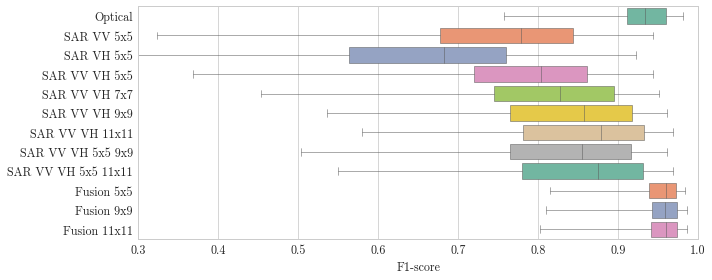

In [385]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.boxplot(ax=ax, data=score_per_scheme, orient='h', whis='range', width=0.80, linewidth=0.5, palette='Set2')
ax.set_xticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.])
ax.set_xlim((0.3, 1.))
ax.set_xlabel('F1-score')
fig.tight_layout()
fig.savefig(os.path.join(output_dir, 'score_per_scheme_boxplot.svg'))
fig.savefig(os.path.join(output_dir, 'score_per_scheme_boxplot.pdf'))
fig.savefig(os.path.join(output_dir, 'score_per_scheme_boxplot.png'), dpi=600)

### Benefit of the fusion

What is the benefit of adding SAR data to the classification for each case study ?

In [24]:
sar_columns = [col for col in score_per_scheme.columns if 'SAR' in col]
fusion_columns = [col for col in score_per_scheme.columns if 'Fusion' in col]
sar_scores = score_per_scheme[sar_columns].max(axis=1)
fusion_scores = score_per_scheme[fusion_columns].max(axis=1)

In [28]:
fusion_benefit = (fusion_scores - score_per_scheme['Optical']) * 100

In [30]:
fusion_benefit.sort_values(ascending=False)

Chimoio         6.7
Saint-Louis     6.6
Gao             5.8
Bukavu          4.1
Katsina         4.0
Nairobi         2.2
Johannesburg    2.0
Antananarivo    1.4
Dakar           0.8
Kampala         0.6
Ouagadougou     0.5
Windhoek        0.0
dtype: float64

Adding SAR data consistently improves the classification performances, especially in Chimoio (+6.7 points), Saint-Louis (+6.6), Gao (+5.8), Bukavu (4.1) and Katsina (4.0).

### Influence of the climate

Does the climate of the case study has an influence on the benefit of the fusion ?

In [31]:
tropical = ['Antananarivo', 'Bukavu', 'Chimoio', 'Johannesburg', 'Kampala']
arid = ['Dakar', 'Gao', 'Katsina', 'Ouagadougou', 'Saint-Louis', 'Windhoek']

In [35]:
fusion_benefit.loc[arid].mean().round(2), fusion_benefit.loc[tropical].mean().round(2)

(2.95, 2.96)

Fusion benefit does not seem influenced by the climate in the context of our case studies.

### What about standard deviation ?

In [95]:
std_per_scheme = pd.DataFrame(index=CITIES, columns=SCHEMES)
for case_study, scheme in product(CASE_STUDIES, SCHEMES):
    fp = os.path.join(DATA_DIR, 'output', case_study.id, scheme, 'metrics.csv')
    metrics = pd.read_csv(fp, index_col=0)
    std_per_scheme.at[(case_study.name, scheme)] = metrics.std(axis=1).f1_score

In [96]:
std_per_scheme.astype(np.float).round(decimals=3)

,optical,sar_vv_5x5,sar_vh_5x5,sar_vv_vh_5x5,sar_vv_vh_7x7,sar_vv_vh_9x9,sar_vv_vh_11x11,sar_vv_vh_5x5_9x9,sar_vv_vh_5x5_11x11,optical_sar,optical_sar_9x9,optical_sar_11x11
Antananarivo,0.029,0.025,0.045,0.023,0.021,0.017,0.016,0.018,0.015,0.022,0.014,0.014
Bukavu,0.023,0.016,0.032,0.017,0.014,0.012,0.012,0.013,0.012,0.019,0.017,0.017
Chimoio,0.018,0.045,0.020,0.036,0.041,0.039,0.041,0.043,0.048,0.010,0.014,0.015
Dakar,0.017,0.029,0.026,0.025,0.022,0.019,0.017,0.020,0.018,0.017,0.019,0.019
Gao,0.067,0.030,0.043,0.027,0.023,0.027,0.031,0.026,0.029,0.059,0.059,0.056
Johannesburg,0.010,0.018,0.015,0.014,0.012,0.010,0.009,0.010,0.009,0.005,0.005,0.004
Kampala,0.012,0.024,0.032,0.023,0.020,0.018,0.016,0.017,0.016,0.010,0.012,0.014
Katsina,0.046,0.009,0.024,0.008,0.007,0.007,0.008,0.007,0.008,0.026,0.017,0.016
Nairobi,0.015,0.040,0.050,0.031,0.024,0.020,0.018,0.022,0.019,0.014,0.014,0.015
Ouagadougou,0.011,0.072,0.241,0.071,0.056,0.047,0.042,0.052,0.045,0.009,0.009,0.008


In [97]:
std_per_scheme.mean(axis=0).round(3).sort_values()

optical_sar_9x9        0.017
optical_sar_11x11      0.017
optical_sar            0.018
sar_vv_vh_11x11        0.022
sar_vv_vh_9x9          0.023
sar_vv_vh_5x5_11x11    0.023
optical                0.025
sar_vv_vh_5x5_9x9      0.025
sar_vv_vh_7x7          0.026
sar_vv_vh_5x5          0.031
sar_vv_5x5             0.035
sar_vh_5x5             0.052
dtype: float64

### Optical vs. SAR

In [394]:
optical

Antananarivo    0.921
Bukavu          0.917
Chimoio         0.834
Dakar           0.947
Gao             0.757
Johannesburg    0.956
Kampala         0.978
Katsina         0.927
Nairobi         0.941
Ouagadougou     0.981
Saint-Louis     0.894
Windhoek        0.973
Name: Optical, dtype: float64

In [397]:
optical = score_per_scheme.Optical
sar_columns = [column for column in score_per_scheme.columns if 'SAR' in column]
sar = score_per_scheme[sar_columns].max(axis=1)
difference = optical - sar
display(difference)

Antananarivo    0.042
Bukavu         -0.015
Chimoio         0.254
Dakar           0.151
Gao            -0.076
Johannesburg    0.024
Kampala         0.009
Katsina        -0.034
Nairobi         0.039
Ouagadougou     0.244
Saint-Louis     0.225
Windhoek        0.094
dtype: float64

In [406]:
fusion_columns = [col for col in score_per_scheme.columns if 'Fusion' in col]
fusion = score_per_scheme[fusion_columns].max(axis=1)
difference = fusion - score_per_scheme[sar_columns + ['Optical']].max(axis=1)
display(difference.sort_values(ascending=False))

Chimoio         0.067
Saint-Louis     0.066
Bukavu          0.026
Nairobi         0.022
Johannesburg    0.020
Antananarivo    0.014
Dakar           0.008
Katsina         0.006
Kampala         0.006
Ouagadougou     0.005
Windhoek        0.000
Gao            -0.018
dtype: float64

In [409]:
(fusion - score_per_scheme.Optical).sort_values(ascending=False)

Chimoio         0.067
Saint-Louis     0.066
Gao             0.058
Bukavu          0.041
Katsina         0.040
Nairobi         0.022
Johannesburg    0.020
Antananarivo    0.014
Dakar           0.008
Kampala         0.006
Ouagadougou     0.005
Windhoek        0.000
dtype: float64

### Accuracy in bare soil areas

In [59]:
accuracy_baresoil = pd.DataFrame(index=CITIES, columns=SCHEMES, dtype=np.float)
for case_study, scheme in product(CASE_STUDIES, SCHEMES):
    fp = os.path.join(DATA_DIR, 'output', case_study.id, scheme, 'metrics.csv')
    metrics = pd.read_csv(fp, index_col=0).mean(axis=1)
    accuracy_baresoil.at[(case_study.name, scheme)] = metrics.at[('baresoil_accuracy')]

In [60]:
accuracy_baresoil.round(3)

,optical,sar_vv_5x5,sar_vh_5x5,sar_vv_vh_5x5,sar_vv_vh_7x7,sar_vv_vh_9x9,sar_vv_vh_11x11,sar_vv_vh_5x5_9x9,sar_vv_vh_5x5_11x11,optical_sar,optical_sar_9x9,optical_sar_11x11
Antananarivo,0.965,0.986,0.979,0.984,0.982,0.981,0.981,0.984,0.984,0.969,0.969,0.970
Bukavu,0.900,0.952,0.983,0.964,0.966,0.971,0.980,0.971,0.977,0.947,0.957,0.964
Chimoio,0.916,0.962,0.997,0.961,0.955,0.950,0.948,0.951,0.952,0.978,0.982,0.985
Dakar,0.910,0.995,0.998,0.996,0.997,0.998,0.997,0.999,0.998,0.969,0.979,0.978
Gao,0.906,0.991,0.978,0.990,0.989,0.988,0.985,0.989,0.988,0.950,0.951,0.950
Johannesburg,0.791,0.879,0.950,0.924,0.923,0.925,0.928,0.929,0.931,0.923,0.935,0.939
Kampala,0.978,0.969,0.989,0.979,0.979,0.981,0.984,0.984,0.986,0.988,0.995,0.997
Katsina,0.982,0.989,0.988,0.987,0.986,0.987,0.988,0.986,0.987,0.991,0.989,0.988
Nairobi,0.838,0.991,0.999,0.995,0.995,0.996,0.997,0.996,0.996,0.971,0.982,0.984
Ouagadougou,0.996,0.996,0.992,0.997,0.997,0.997,0.996,0.997,0.997,0.999,1.000,0.999


In [61]:
accuracy_baresoil.mean(axis=0).round(2)

optical                0.93
sar_vv_5x5             0.97
sar_vh_5x5             0.99
sar_vv_vh_5x5          0.98
sar_vv_vh_7x7          0.98
sar_vv_vh_9x9          0.98
sar_vv_vh_11x11        0.98
sar_vv_vh_5x5_9x9      0.98
sar_vv_vh_5x5_11x11    0.98
optical_sar            0.97
optical_sar_9x9        0.98
optical_sar_11x11      0.98
dtype: float64

#### Fusion benefit in bare soil areas

What is the improvement, in each case study, of the classification accuracy in bare soil areas when adding SAR features ?

In [62]:
fusion_benefit_baresoil = (accuracy_baresoil.optical_sar_9x9 - accuracy_baresoil.optical) * 100
fusion_benefit_baresoil.astype(np.float).round(2).sort_values(ascending=False)

Johannesburg    14.41
Nairobi         14.34
Dakar            6.91
Chimoio          6.62
Bukavu           5.71
Gao              4.49
Kampala          1.70
Katsina          0.71
Saint-Louis      0.67
Windhoek         0.61
Antananarivo     0.40
Ouagadougou      0.39
dtype: float64

Adding SAR features greatly increases the accuracy of the classification in bare soil areas, especially un Nairobi, Johannesburg, Chimoio, Dakar, Bukavu and Gao.

### Accuracy highly vegetated areas

In [63]:
accuracy_highveg = pd.DataFrame(index=CITIES, columns=SCHEMES, dtype=np.float)
for case_study, scheme in product(CASE_STUDIES, SCHEMES):
    fp = os.path.join(DATA_DIR, 'output', case_study.id, scheme, 'metrics.csv')
    metrics = pd.read_csv(fp, index_col=0).mean(axis=1)
    accuracy_highveg.at[(case_study.name, scheme)] = metrics.at[('highveg_accuracy')]

In [64]:
accuracy_highveg.round(3)

,optical,sar_vv_5x5,sar_vh_5x5,sar_vv_vh_5x5,sar_vv_vh_7x7,sar_vv_vh_9x9,sar_vv_vh_11x11,sar_vv_vh_5x5_9x9,sar_vv_vh_5x5_11x11,optical_sar,optical_sar_9x9,optical_sar_11x11
Antananarivo,1.000,0.973,0.927,0.962,0.957,0.954,0.954,0.961,0.961,1.000,1.000,1.000
Bukavu,1.000,0.951,0.909,0.937,0.924,0.931,0.944,0.936,0.948,1.000,0.999,0.999
Chimoio,1.000,0.963,0.994,0.962,0.954,0.938,0.939,0.955,0.955,1.000,1.000,1.000
Dakar,0.997,0.916,0.859,0.879,0.873,0.867,0.868,0.875,0.876,0.995,0.994,0.994
Gao,0.982,0.152,0.379,0.540,0.657,0.695,0.677,0.706,0.685,0.986,0.992,0.994
Johannesburg,0.980,0.681,0.569,0.671,0.691,0.701,0.710,0.712,0.723,0.984,0.971,0.964
Kampala,1.000,0.982,0.964,0.982,0.982,0.982,0.985,0.984,0.986,1.000,1.000,1.000
Katsina,0.998,0.803,0.123,0.810,0.832,0.854,0.847,0.865,0.858,0.998,0.998,0.998
Nairobi,1.000,0.925,0.942,0.960,0.956,0.952,0.956,0.962,0.964,1.000,1.000,1.000
Ouagadougou,1.000,0.644,0.484,0.577,0.575,0.568,0.557,0.570,0.559,1.000,1.000,1.000


In [65]:
accuracy_highveg.mean(axis=0).round(3)

optical                0.996
sar_vv_5x5             0.824
sar_vh_5x5             0.752
sar_vv_vh_5x5          0.848
sar_vv_vh_7x7          0.856
sar_vv_vh_9x9          0.859
sar_vv_vh_11x11        0.858
sar_vv_vh_5x5_9x9      0.868
sar_vv_vh_5x5_11x11    0.867
optical_sar            0.997
optical_sar_9x9        0.996
optical_sar_11x11      0.995
dtype: float64

## Accuracy lowly vegetated areas

In [66]:
accuracy_lowveg = pd.DataFrame(index=CITIES, columns=SCHEMES, dtype=np.float)
for case_study, scheme in product(CASE_STUDIES, SCHEMES):
    fp = os.path.join(DATA_DIR, 'output', case_study.id, scheme, 'metrics.csv')
    metrics = pd.read_csv(fp, index_col=0).mean(axis=1)
    accuracy_lowveg.at[(case_study.name, scheme)] = metrics.at[('lowveg_accuracy')]

In [67]:
accuracy_lowveg.round(3)

,optical,sar_vv_5x5,sar_vh_5x5,sar_vv_vh_5x5,sar_vv_vh_7x7,sar_vv_vh_9x9,sar_vv_vh_11x11,sar_vv_vh_5x5_9x9,sar_vv_vh_5x5_11x11,optical_sar,optical_sar_9x9,optical_sar_11x11
Antananarivo,0.988,0.991,0.999,0.993,0.992,0.992,0.992,0.993,0.993,0.996,0.995,0.995
Bukavu,0.989,0.961,0.971,0.971,0.970,0.970,0.974,0.971,0.976,0.997,0.998,0.996
Chimoio,0.911,0.992,0.995,0.989,0.980,0.961,0.953,0.977,0.970,0.931,0.936,0.942
Dakar,0.986,0.920,0.895,0.901,0.898,0.894,0.887,0.897,0.892,0.992,0.989,0.988
Gao,0.894,0.397,0.526,0.512,0.569,0.634,0.655,0.603,0.638,0.805,0.820,0.813
Johannesburg,0.927,0.875,0.886,0.900,0.910,0.915,0.919,0.920,0.923,0.968,0.961,0.959
Kampala,0.991,0.993,0.987,0.994,0.995,0.994,0.994,0.995,0.994,0.997,0.997,0.996
Katsina,0.976,0.957,0.904,0.956,0.958,0.955,0.951,0.956,0.954,0.994,0.993,0.993
Nairobi,0.965,0.964,0.971,0.975,0.971,0.968,0.962,0.973,0.968,0.980,0.977,0.971
Ouagadougou,0.999,0.973,0.947,0.971,0.972,0.973,0.973,0.975,0.975,1.000,1.000,1.000


In [68]:
accuracy_lowveg.mean(axis=0).round(3)

optical                0.968
sar_vv_5x5             0.916
sar_vh_5x5             0.921
sar_vv_vh_5x5          0.927
sar_vv_vh_7x7          0.930
sar_vv_vh_9x9          0.933
sar_vv_vh_11x11        0.933
sar_vv_vh_5x5_9x9      0.934
sar_vv_vh_5x5_11x11    0.936
optical_sar            0.971
optical_sar_9x9        0.972
optical_sar_11x11      0.970
dtype: float64

In [69]:
accuracy_builtup = pd.DataFrame(index=CITIES, columns=SCHEMES, dtype=np.float)
for case_study, scheme in product(CASE_STUDIES, SCHEMES):
    fp = os.path.join(DATA_DIR, 'output', case_study.id, scheme, 'metrics.csv')
    metrics = pd.read_csv(fp, index_col=0).mean(axis=1)
    accuracy_builtup.at[(case_study.name, scheme)] = metrics.at[('builtup_accuracy')]

In [70]:
accuracy_builtup.mean(axis=0).round(3)

optical                0.888
sar_vv_5x5             0.648
sar_vh_5x5             0.522
sar_vv_vh_5x5          0.677
sar_vv_vh_7x7          0.721
sar_vv_vh_9x9          0.756
sar_vv_vh_11x11        0.780
sar_vv_vh_5x5_9x9      0.749
sar_vv_vh_5x5_11x11    0.774
optical_sar            0.915
optical_sar_9x9        0.918
optical_sar_11x11      0.916
dtype: float64

In [108]:
land_cover_accuracies = pd.DataFrame(index=SCHEMES_LABELS)
land_cover_accuracies['Bare soil'] = accuracy_baresoil.mean(axis=0).values
land_cover_accuracies['Bare soil std'] = accuracy_baresoil.std(axis=0).values
land_cover_accuracies['Low vegetation'] = accuracy_lowveg.mean(axis=0).values
land_cover_accuracies['Low vegetation std'] = accuracy_lowveg.std(axis=0).values
land_cover_accuracies['High vegetation'] = accuracy_highveg.mean(axis=0).values
land_cover_accuracies['High vegetation std'] = accuracy_highveg.std(axis=0).values
land_cover_accuracies.index.name = 'Scheme'

In [109]:
land_cover_accuracies

,Bare soil,Bare soil std,Low vegetation,Low vegetation std,High vegetation,High vegetation std
Scheme,,,,,,
Optical,0.929980,0.065595,0.968470,0.037026,0.995744,0.007304
SAR VV 5x5,0.974399,0.033369,0.916277,0.167326,0.823519,0.240505
SAR VH 5x5,0.986372,0.013779,0.920950,0.130958,0.752466,0.289289
SAR VV VH 5x5,0.980072,0.021447,0.927196,0.134464,0.847985,0.161382
SAR VV VH 7x7,0.978928,0.021859,0.930386,0.117776,0.856413,0.138477
SAR VV VH 9x9,0.979103,0.021828,0.932816,0.098441,0.859318,0.132399
SAR VV VH 11x11,0.979494,0.021398,0.932551,0.092459,0.858372,0.136588
SAR VV VH 5x5 9x9,0.980415,0.021311,0.934262,0.108337,0.867811,0.133102
SAR VV VH 5x5 11x11,0.980864,0.020424,0.935738,0.098070,0.866560,0.137247


In [110]:
LAND_COVERS = ['Bare soil', 'Low vegetation', 'High vegetation']
COLORS = ['darkorange', 'lightgreen', 'forestgreen']

In [111]:
land_cover_accuracies.loc['Fusion 11x11'][['Bare soil', 'Low vegetation', 'High vegetation']]

Bare soil          0.978784
Low vegetation     0.970345
High vegetation    0.994900
Name: Fusion 11x11, dtype: float64

In [112]:
land_cover_accuracies = land_cover_accuracies.reindex(list(reversed(SCHEMES_LABELS)))

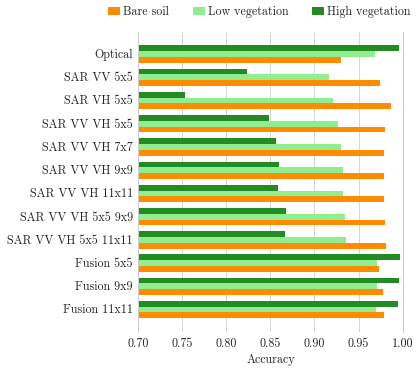

In [113]:
fig, ax = plt.subplots(figsize=(6, 5))
n = len(land_cover_accuracies.index)
yloc = np.arange(n)
height = 0.25

for i, (land_cover, color) in enumerate(zip(LAND_COVERS, COLORS)):
    ax.barh(
        yloc + height * i, land_cover_accuracies[land_cover],
        height=height, color=color, label=land_cover
    )

ax.set_xlim(0.7, 1)
ax.set_yticks(np.arange(n) + 0.3)
ax.set_yticklabels(list(reversed(SCHEMES_LABELS)))
ax.set_xlabel('Accuracy')
ax.yaxis.grid(False)
ax.xaxis.grid(True)
for loc in ('top', 'bottom'):
    ax.spines[loc].set_visible(False)

fig.legend(ncol=3, fancybox=True, loc='upper center', bbox_to_anchor=(0.6, 1.05), handlelength=1, handletextpad=0.25)

fig.tight_layout()

fig.savefig(os.path.join(output_dir, 'accuracy_per_landcover.svg'), bbox_inches='tight')
fig.savefig(os.path.join(output_dir, 'accuracy_per_landcover.pdf'), bbox_inches='tight')
fig.savefig(os.path.join(output_dir, 'accuracy_per_landcover.png'), bbox_inches='tight', dpi=600)

## Feature importances

### Optical vs. SAR

In [75]:
feature_importances = pd.DataFrame(index=CITIES, columns=['vv', 'vh', 'ms', 'tir'])
for case_study in CASE_STUDIES:
    fp = os.path.join(DATA_DIR, 'output', case_study.id, 'optical_sar_11x11', 'features_importances.csv')
    importances = pd.read_csv(fp, index_col=0).mean(axis=1)
    feature_importances.at[(case_study.name, 'vv')] = importances[importances.index.str.contains('vv')].sum()
    feature_importances.at[(case_study.name, 'vh')] = importances[importances.index.str.contains('vh')].sum()
    feature_importances.at[(case_study.name, 'ms')] = importances[importances.index.isin(['red', 'green', 'blue', 'swir1', 'swir2', 'nir'])].sum()
    feature_importances.at[(case_study.name, 'tir')] = importances[importances.index.str.contains('tir')].sum()

In [76]:
feature_importances.astype(np.float).round(2)

,vv,vh,ms,tir
Antananarivo,0.35,0.22,0.28,0.14
Bukavu,0.35,0.20,0.40,0.04
Chimoio,0.15,0.10,0.47,0.28
Dakar,0.21,0.21,0.50,0.07
Gao,0.32,0.18,0.36,0.13
Johannesburg,0.37,0.37,0.20,0.05
Kampala,0.28,0.09,0.41,0.22
Katsina,0.48,0.21,0.28,0.02
Nairobi,0.27,0.36,0.31,0.07
Ouagadougou,0.24,0.19,0.30,0.26


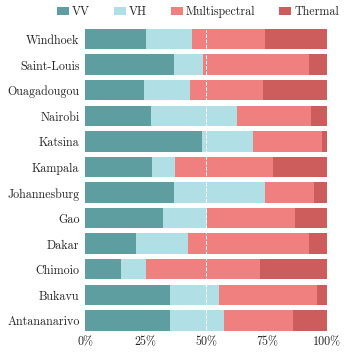

In [77]:
fig, ax = plt.subplots(figsize=(5, 5))

n = len(feature_importances.index)
y = np.arange(n)
h = 0.5

ax.barh(y, feature_importances.vv, color='cadetblue', label='VV')
ax.barh(y, feature_importances.vh, left=feature_importances.vv, color='powderblue', label='VH')
ax.barh(y, feature_importances.ms, left=feature_importances.vh + feature_importances.vv, color='lightcoral', label='Multispectral')
ax.barh(y, feature_importances.tir, left=feature_importances.vv + feature_importances.vh + feature_importances.ms, color='indianred', label='Thermal')

ax.set_yticks(y)
ax.set_yticklabels(feature_importances.index)
ax.set_xticks([0, 0.25, 0.5, 0.75, 1])
ax.set_xticklabels(['0%', '25%', '50%', '75%', '100%'])
ax.set_xlim(0, 1)
for loc in ('top', 'bottom', 'left', 'right'):
    ax.spines[loc].set_visible(False)
ax.grid(False)
ax.tick_params(axis='x', pad=-10)
ax.axvline(x=0.5, ymin=0.05, ymax=0.95, color='white', linewidth=1, linestyle='dashed')

fig.legend(ncol=4, fancybox=True, loc='upper center', bbox_to_anchor=(0.55, 1.0), handlelength=1, handletextpad=0.25)

fig.tight_layout()

fig.savefig(os.path.join(output_dir, 'feature_importances.svg'), bbox_inches='tight')
fig.savefig(os.path.join(output_dir, 'feature_importances.pdf'), bbox_inches='tight')
fig.savefig(os.path.join(output_dir, 'feature_importances.png'), bbox_inches='tight', dpi=600)

### SAR importance

In [78]:
sar_importance = feature_importances.vv + feature_importances.vh
sar_importance.astype(float).round(2).sort_values(ascending=False)

Johannesburg    0.74
Katsina         0.69
Nairobi         0.63
Antananarivo    0.57
Bukavu          0.55
Gao             0.50
Saint-Louis     0.49
Windhoek        0.44
Ouagadougou     0.43
Dakar           0.42
Kampala         0.37
Chimoio         0.25
dtype: float64